I explore a database of Gamma Ray Bursts and I use K-Means and Mean Shift to identify different populations in the data.

In [24]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st
import sklearn.manifold
import sklearn.model_selection

# Exploration of the dataset

I read the file containing the dataset and I prepare the arrays containing time, flux and redshift.

In [25]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [26]:
#cleaning the data from no actual data (-999 values) and transform them from strings to floats
mask_time = data[names=='T90']!='-999'
mask_fluence = data[names=='fluence']!='-999'
mask_time_err = data[names=='T90_error']!='-999'
mask_fluence_err = data[names=='fluence_error']!='-999'
mask_redshift = data[names=='redshift']!='-999'

# time, flux, redshift
time = np.float64(data[names=='T90'][mask_time&mask_fluence&mask_time_err&mask_fluence_err])
flux = np.float64(data[names=='fluence'][mask_time&mask_fluence&mask_time_err&mask_fluence_err])
flux_z = np.float64(data[names=='fluence'][mask_redshift&mask_fluence&mask_time])
time_z = np.float64(data[names=='T90'][mask_time&mask_fluence&mask_redshift])
z = np.float64(data[names=='redshift'][mask_redshift&mask_fluence&mask_time])

# errors
time_err = np.float64(data[names=='T90_error'][mask_time&mask_fluence&mask_time_err&mask_fluence_err])
flux_err = np.float64(data[names=='fluence_error'][mask_time&mask_fluence&mask_time_err&mask_fluence_err])

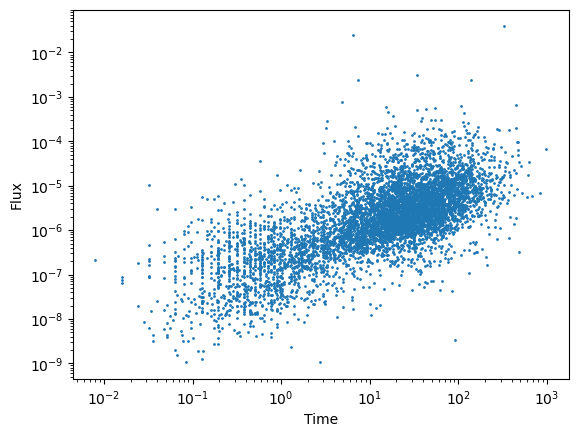

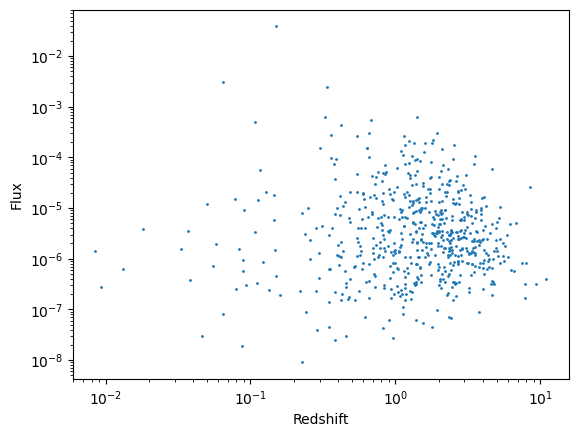

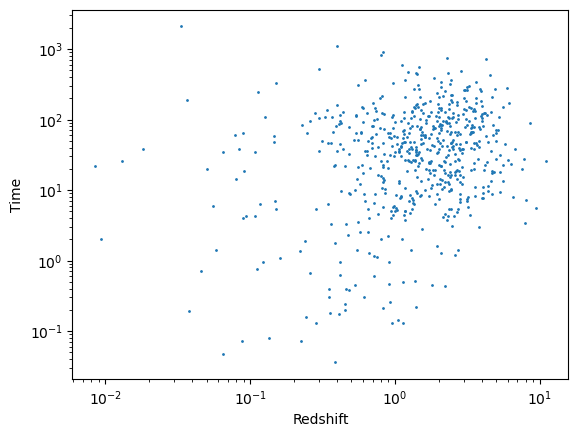

In [27]:
# I visualize the flux vs time and redshift
plt.scatter(time, flux, s=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

plt.scatter(z, flux_z, s=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel('Flux')
plt.show()

plt.scatter(z, time_z, s=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel('Time')
plt.show()

# 1D clustering of time

In [28]:
from sklearn import preprocessing

log_time = np.log10(time[(time!=0) & (flux!=0)])
log_time = log_time[:,np.newaxis]

scaler = preprocessing.StandardScaler()
scaled_X = scaler.fit_transform(log_time)

**K-Means**

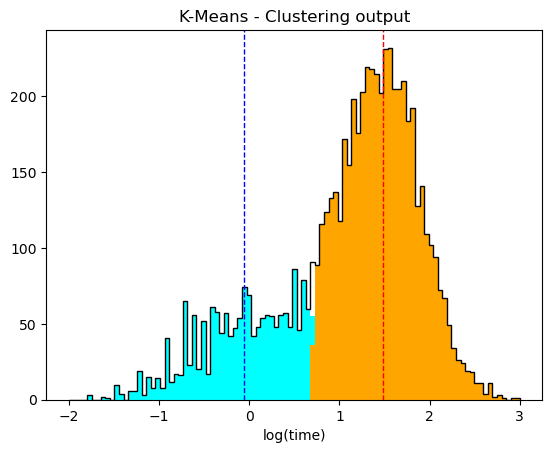

In [29]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_clusters = 2

clf = KMeans(n_clusters,n_init='auto')
clf.fit(scaled_X)
centers_scaled = clf.cluster_centers_ #location of the clusters
centers = scaler.inverse_transform(centers_scaled)
labels = clf.predict(scaled_X)        #labels for each of the points

# plot the data color-coded by cluster id
plt.hist(log_time, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step')
plt.hist(log_time[labels==0], bins=np.linspace(-2, 3, 100), color='cyan')
plt.hist(log_time[labels==1], bins=np.linspace(-2, 3, 100), color='orange') 
plt.axvline(centers[0], c = 'blue', lw = 1, ls = '--')
plt.axvline(centers[1], c = 'red', lw = 1, ls = '--')
plt.xlabel('log(time)')
plt.title('K-Means - Clustering output')
plt.show()

This is what we would expect with short and long GRB. K-Means gives a good result.

**Mean Shift**

In [30]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth_est = estimate_bandwidth(scaled_X)
ms = MeanShift(bandwidth=bandwidth_est)
print('Estimated bandwidth: %.2f' % bandwidth_est)
ms.fit(scaled_X)

# number of clusters
labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters_ms = len(labels_unique)
print("Number of estimated clusters: %i" % n_clusters_ms)

# location of the clusters
scaled_centers_ms = ms.cluster_centers_
centers_ms = scaler.inverse_transform(scaled_centers_ms)

Estimated bandwidth: 0.63
Number of estimated clusters: 1


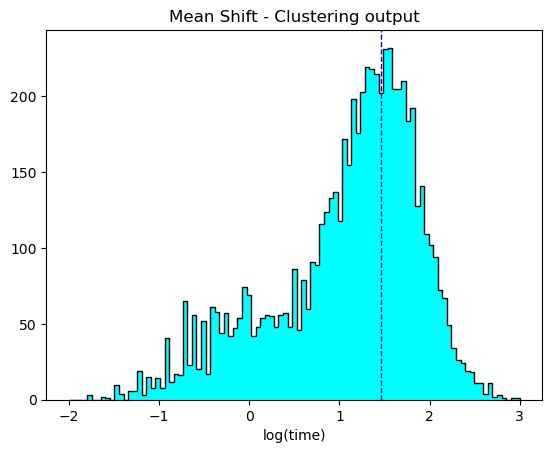

In [31]:
# plot the data color-coded by cluster id
plt.hist(log_time, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step')
plt.hist(log_time[labels_ms==0], bins=np.linspace(-2, 3, 100), color='cyan')
plt.hist(log_time[labels_ms==1], bins=np.linspace(-2, 3, 100), color='orange') 
plt.axvline(centers_ms[0], c = 'blue', lw = 1, ls = '--')
#plt.axvline(centers_ms[1], c = 'red', lw = 1, ls = '--')
plt.xlabel('log(time)')
plt.title('Mean Shift - Clustering output')
plt.show()

I am not satisfied. Does the result change if I define a smaller bandwidth value?

Number of estimated clusters: 2


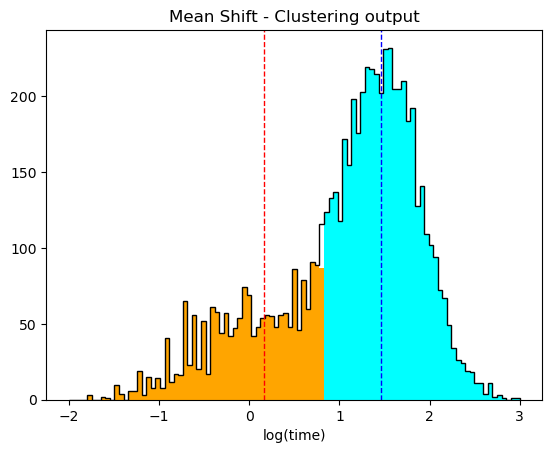

In [32]:
bandwidth_defined = 0.5
ms = MeanShift(bandwidth=bandwidth_defined)
ms.fit(scaled_X)

# number of clusters
labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters_ms = len(labels_unique)
print("Number of estimated clusters: %i" % n_clusters_ms)

# location of the clusters
scaled_centers_ms = ms.cluster_centers_
centers_ms = scaler.inverse_transform(scaled_centers_ms)

# plot the data color-coded by cluster id
plt.hist(log_time, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step')
plt.hist(log_time[labels_ms==0], bins=np.linspace(-2, 3, 100), color='cyan')
plt.hist(log_time[labels_ms==1], bins=np.linspace(-2, 3, 100), color='orange') 
plt.axvline(centers_ms[0], c = 'blue', lw = 1, ls = '--')
plt.axvline(centers_ms[1], c = 'red', lw = 1, ls = '--')
plt.xlabel('log(time)')
plt.title('Mean Shift - Clustering output')
plt.show()

# 2D  clustering of flux vs time diagram

In [33]:
log_time = np.log10(time[(time!=0) & (flux!=0)])
log_flux = np.log10(flux[(time!=0) & (flux!=0)])
X = np.vstack([log_time, log_flux]).T

scaler = preprocessing.StandardScaler()
scaled_X = scaler.fit_transform(X)

**K-Means**

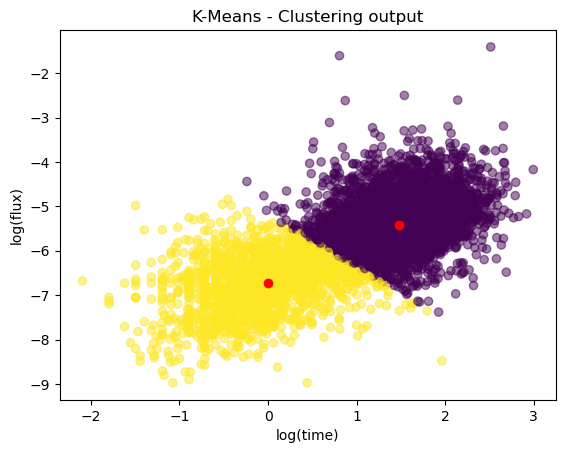

In [34]:
n_clusters = 2

clf = KMeans(n_clusters,n_init='auto')
clf.fit(scaled_X)
centers_scaled = clf.cluster_centers_ #location of the clusters
centers = scaler.inverse_transform(centers_scaled)
labels = clf.predict(scaled_X)        #labels for each of the points

# plot the data color-coded by cluster id
plt.scatter(X[:,0], X[:,1], c=labels, alpha = 0.5)
plt.scatter(centers[:,0], centers[:,1], color='red')
plt.xlabel('log(time)')
plt.ylabel('log(flux)')
plt.title('K-Means - Clustering output')
plt.show()

This is what we would expect with short and long GRB. K-Means gives a good result.

**Mean Shift**

In [35]:
bandwidth_est = estimate_bandwidth(scaled_X)
ms = MeanShift(bandwidth=bandwidth_est)
print('Estimated bandwidth: %.2f' % bandwidth_est)
ms.fit(scaled_X)

# number of clusters
labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters_ms = len(labels_unique)
print("Number of estimated clusters: %i" % n_clusters_ms)

# location of the clusters
scaled_centers_ms = ms.cluster_centers_
centers_ms = scaler.inverse_transform(scaled_centers_ms)

Estimated bandwidth: 1.11
Number of estimated clusters: 4


[[ 1.41850494 -5.55666773]
 [ 2.5129924  -1.41076551]
 [ 1.96151601 -8.47790804]
 [ 0.80617997 -1.60899428]]


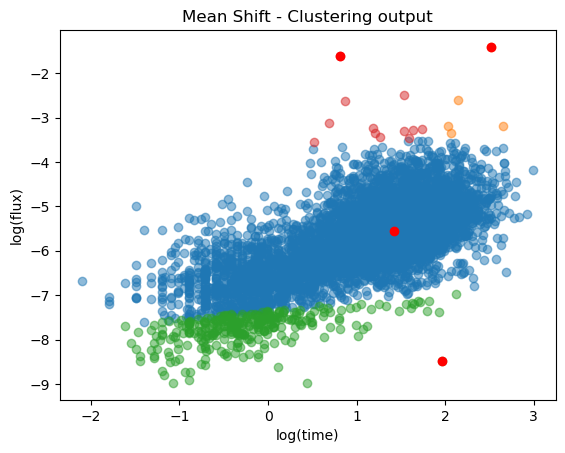

In [36]:
# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for i in labels_unique:
    plt.scatter(X[:, 0][labels_ms==i], X[:, 1][labels_ms==i], color = colors[i], alpha = 0.5)

print(centers_ms)
plt.scatter(centers_ms[:,0], centers_ms[:,1], color='red')
plt.xlabel('log(time)')
plt.ylabel('log(flux)')
plt.title('Mean Shift - Clustering output')
plt.show()

I am not satisfied. Does the result change if I cut off outliers?

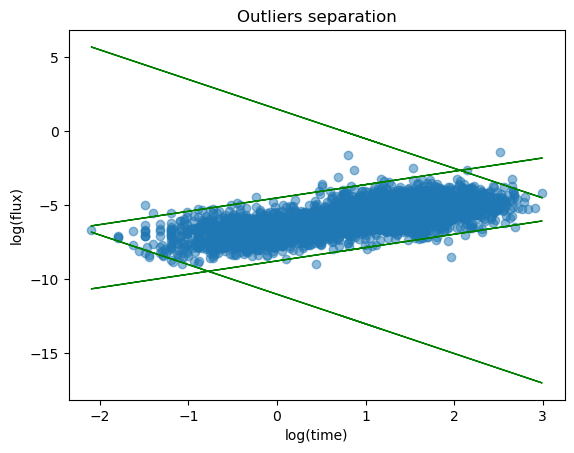

In [37]:
# I define the outliers

plt.scatter(log_time, log_flux, alpha=0.5)

x_f = log_time
y_dw = (0.9)*x_f -8.75
plt.plot(x_f,y_dw, 'green', lw=1)
y_up = (0.9)*x_f - 4.5
plt.plot(x_f,y_up, 'green', lw=1)
y_r = (-2)*x_f + 1.5
plt.plot(x_f,y_r, 'green', lw=1)
y_l = (-2)*x_f - 11.0
plt.plot(x_f,y_l, 'green', lw=1)
plt.title('Outliers separation')
plt.xlabel('log(time)')
plt.ylabel('log(flux)')
plt.show()

In [38]:
# I cut off outliers
mask_down = X[:,1]>(0.9*X[:,0] -8.75)
mask_up = X[:,1]<(0.9*X[:,0] -4.5)
mask_left = X[:,1]>(-2*X[:,0] -11.0)
mask_right = X[:,1]<(-2*X[:,0] +1.5)

X_cut = X[mask_down&mask_up&mask_left&mask_right]

In [39]:
# I re-try with Mean Shift

scaled_X = scaler.fit_transform(X_cut)

bandwidth_est = estimate_bandwidth(scaled_X)
ms = MeanShift(bandwidth=bandwidth_est)
print('Estimated bandwidth: %.2f' % bandwidth_est)
ms.fit(scaled_X)

# number of clusters
labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters_ms = len(labels_unique)
print("Number of estimated clusters: %i" % n_clusters_ms)

# location of the clusters
scaled_centers_ms = ms.cluster_centers_
centers_ms = scaler.inverse_transform(scaled_centers_ms)

Estimated bandwidth: 1.11
Number of estimated clusters: 1


[[ 1.4170606  -5.55850012]]


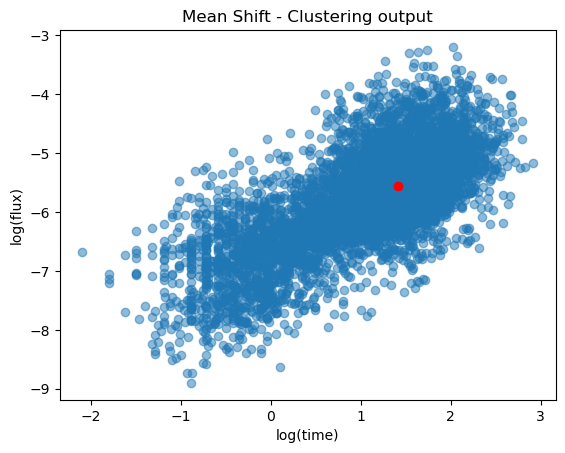

In [40]:
# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for i in labels_unique:
    plt.scatter(X_cut[:, 0][labels_ms==i], X_cut[:, 1][labels_ms==i], color = colors[i], alpha = 0.5)

print(centers_ms)
plt.scatter(centers_ms[:,0], centers_ms[:,1], color='red')
plt.xlabel('log(time)')
plt.ylabel('log(flux)')
plt.title('Mean Shift - Clustering output')
plt.show()

I am not satisfied yet. Does the result change if I define a smaller bandwidth value?

In [41]:
bandwidth_defined = bandwidth_est/2
ms = MeanShift(bandwidth=bandwidth_defined)
ms.fit(scaled_X)

# number of clusters
labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters_ms = len(labels_unique)
print("Number of estimated clusters: %i" % n_clusters_ms)

# location of the clusters
scaled_centers_ms = ms.cluster_centers_
centers_ms = scaler.inverse_transform(scaled_centers_ms)

Number of estimated clusters: 2


[[ 1.48164433 -5.58712186]
 [-2.09691001 -6.68031111]]


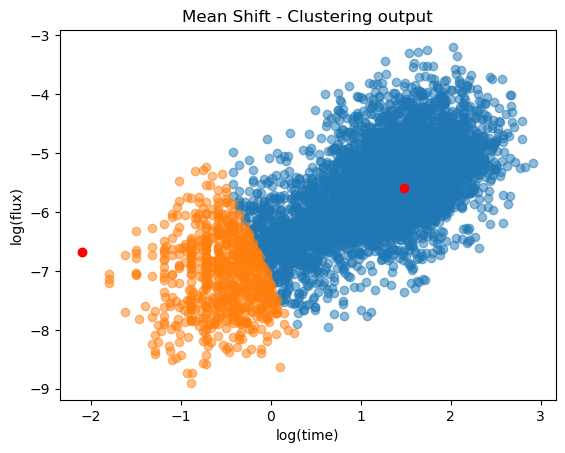

In [42]:
# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for i in labels_unique:
    plt.scatter(X_cut[:, 0][labels_ms==i], X_cut[:, 1][labels_ms==i], color = colors[i], alpha = 0.5)

print(centers_ms)
plt.scatter(centers_ms[:,0], centers_ms[:,1], color='red')
plt.xlabel('log(time)')
plt.ylabel('log(flux)')
plt.title('Mean Shift - Clustering output')
plt.show()

With Mean Shift I struggle to identify the 2 populations. If I discard more outliers, the algorithm finds always only 1 cluster.

# Errors

In my exploration I neglected the errors. Is it acceptable?

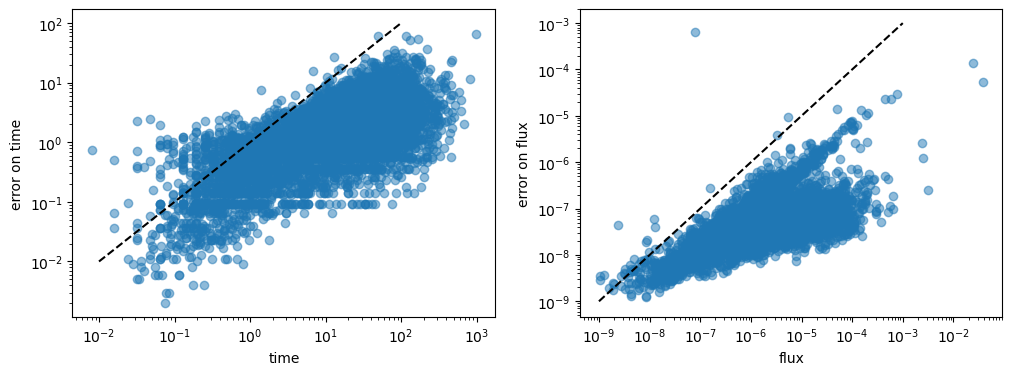

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

times = time[time_err>0]
errortimes = time_err[time_err>0]

ax[0].scatter(times, errortimes, alpha = 0.5)
ax[0].plot([1e-2,1e2],[1e-2,1e2], c = 'black', ls = '--')
ax[0].set_xlabel('time')
ax[0].set_ylabel('error on time')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

fluxes = flux[flux_err>0]
errorfluxes = flux_err[flux_err>0]

ax[1].scatter(flux, flux_err, alpha = 0.5)
ax[1].plot([1e-9,1e-3],[1e-9,1e-3], c = 'black', ls = '--')
ax[1].set_xlabel('flux')
ax[1].set_ylabel('error on flux')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

plt.show()

Regarding the flux, the errors are generally smaller than the distribution of the flux itself, so neglecting errors is acceptable.

Regarding the duration, this is true for the long GRB, while for smaller values of time it's not.